# More on Machine Learning Models

This is the last Python/Pytorch refresher tutorial before we start with the actual course related labs. 

We already showed you how you can create machine learning models with PyTorch and also how to train them. In the previous tutorial we also showed you how to download and load the MNIST and CIFAR-10 datasets using PyTorch. This final tutorial will give a more detailed explanation on what options you have to train your machine learning model using these same datasets. We will show you how you can directly use the datasets or first wrap them in DataLoaders and then batch by batch train your model. Moreover, we will split the training set in a training and validation set for improved training and also show you how you can perform cross validation. 

We want to make sure you know how to perform the training and testing of your models. After this tutorial we will expect that you will know how to prepare your data, design your model and then train and test it. This gives us more time to help you with course related topics. So if you are stuck during the labs or with any of the homework assignments, please remember to take another look at these tutorials. You might find some answers here.

Below we will first import some necessary packages, set the device and already load the MNIST data. We will provide a CNN model for you to use during this tutorial as well as some helper methods. 

## Imports

Below we import some necessary PyTorch packages and some others for plotting or computing.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

#PyTorch Specific libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

## Device
This piece of code is required to make use of the GPU instead of CPU for faster processing

In [2]:
# This piece of code is required to make use of the GPU instead of CPU for faster processing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data

Like explained in a previous tutorial, we will load the training and test set of the MNIST dataset. We already transform all data to tensor format.

In [4]:
# DataLoaders code
train_set = torchvision.datasets.MNIST(root='d:\Datasets', transform=transforms.Compose([transforms.ToTensor()]), download=True, train=True)
test_set = torchvision.datasets.MNIST(root='d:\Datasets', transform=transforms.Compose([transforms.ToTensor()]), download=True, train=False)

## Model

Below you will find a standard CNN model architecture which you may use during this tutorial. Layers and related parts are explained in a previous tutorial, so for information on these topics please take another look at that specific notebook.

In [5]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 128, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(p=0.3)
        
        self.conv2 = nn.Conv2d(128, 224, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(224*4*4, 64)
        self.drop3 = nn.Dropout(p=0.4)
        
        self.fc4 = nn.Linear(64, 32)
        self.drop4 = nn.Dropout(p=0.4)
        
        self.fc5 = nn.Linear(32, 10)
        self.softmax = nn.Softmax(dim=1)
   
    
    def forward(self, x):
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        x = x.view(-1,224*4*4)
        x = self.drop3(F.relu(self.fc3(x)))
        x = self.drop4(F.relu(self.fc4(x)))
        x = self.softmax(self.fc5(x))
        return x

## Evaluation Metric

Below is a method you can use to compute the accuracy of your model. You need to provide output labels (predictions) and original labels. Outputs should be the output of your model and labels should be a tensor filled with Integers.

In [6]:
# Method to compute accuracy
def accuracy(outputs,labels):
    _, preds = torch.max(outputs, dim=1)
    return (torch.tensor(torch.sum(preds == labels).item() / len(preds)))

## Plotting

`plot_predictions()` can be used to plot images with their correct label and the prediction label.

In [7]:
def plot_predictions(images,labels,preds):
    # convert images to numpy arrays
    np_images = images.detach().cpu().numpy()

    # Make sure we can view the images
    # First multiplying by 255 so the values are between 0 and 255
    # Then reshaping the image so the rows and columns are in the correct order.
    np_images = np_images*255
    np_images = [image.astype(np.uint8).reshape((28, 28, 1)) for image in np_images]

    # Plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 8))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(np_images[idx], cmap='gray')
        ax.set_title(f"True Label = {labels[idx]};\n Prediction = {preds[idx]}")

`visualize_batch()` can be used to plot a batch of images and their corresponding labels.

In [8]:
def visualize_batch(images,labels):
    # making sure we can view the images
    images = images.detach().numpy()
    images = images*255
    images = [image.astype(np.uint8).reshape((28, 28, 1)) for image in images]
    
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(images[idx], cmap='gray')
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(str(labels[idx].item()))
    plt.show()

`get_batch_predictions()` can be used to obtain just one batch of images and labels from a dataloader and then create predictions/outputs using your trained model.

In [9]:
def get_batch_predictions(dataloader):
    # obtain one batch of images and labels
    with torch.no_grad():
        model.eval()
        dataiter = iter(test_loader)
        images, labels = next(dataiter)
        images = (images.view(-1,1,28,28)).type(torch.FloatTensor).to(device)
        labels = labels.to(device)
        # Generate predictions
        predictions = model(images)
    return predictions

## Training Without DataLoader

First we will show you how you can train the CNN model without using the DataLoader wrapper, just by iterating over all samples from the training set. We picked Cross Entropy Loss as the loss function and Adam with a learning rate of 0.0015 as the optimizer to be used during training. We will keep it like this for the other parts as well, however, just to be sure that every training is clean we will keep initializing them and the model at the next sections.

First we train the model:

In [10]:
# Define Model
model = CNN().to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0015)

# Execute Training
for image, label in tqdm(train_set):
    # Prepare single image 
    image = image.type(torch.FloatTensor).to(device)
    # Prepare target label
    label = torch.tensor([label], dtype=torch.int8).type(torch.LongTensor).to(device)
    # Generate prediction
    prediction = model(image)
    # Calculate loss
    loss = criterion(prediction, label)
    # Compute gradients
    loss.backward()
    # Update weights
    optimizer.step()
    # Reset gradients
    optimizer.zero_grad()

100%|██████████| 60000/60000 [04:38<00:00, 215.40it/s]


Next, we evaluate the model on the test set:

In [11]:
# Execute Testing
test_loss = []
test_acc = []
test_predictions = []
with torch.no_grad():
    model.eval()

    for image, label in tqdm(test_set):
        # Prepare single image
        image = image.type(torch.FloatTensor).to(device)
        # Prepare target label
        label = torch.tensor([label], dtype=torch.int8).type(torch.LongTensor).to(device)
        # Generate prediction
        prediction = model(image)
        # Calculate loss
        loss = criterion(prediction, label)
        # Compute gradients
        acc = accuracy(prediction, label)
        # Update weights
        test_loss.append(loss)
        # Reset gradients
        test_acc.append(acc)
        # Save prediction for plotting
        test_predictions.append(torch.max(prediction,dim=1)[1].item())
        

# Display Results
print("Test Loss: ", round(torch.stack(test_loss).mean().item(),2))
print("Test Accuracy: ", round(torch.stack(test_acc).mean().item()*100.0,2))

100%|██████████| 10000/10000 [00:35<00:00, 280.78it/s]


Test Loss:  1.89
Test Accuracy:  56.86


Then we plot some test images, their original labels and the predicted labels:

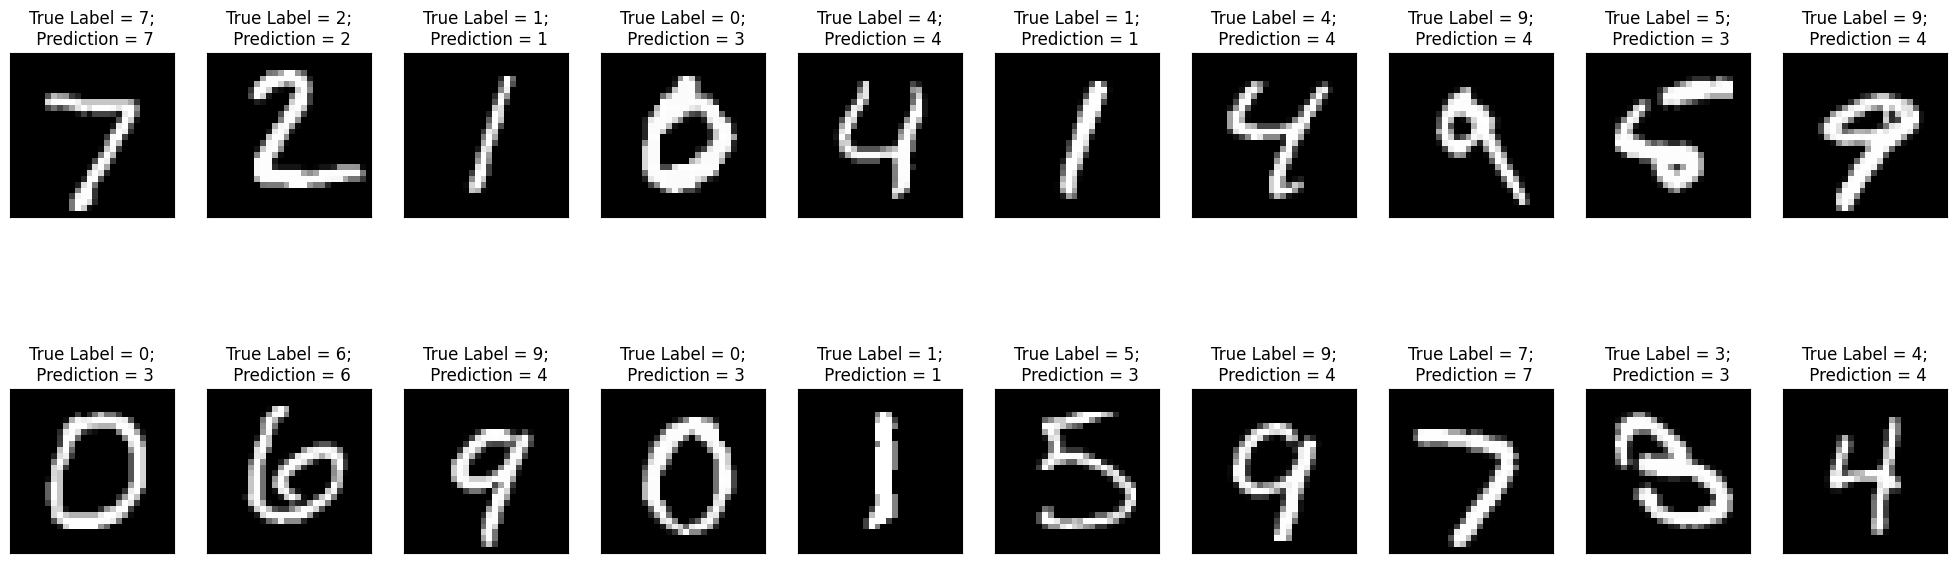

In [13]:
test_images = [test_set[i][0] for i in range(0,20)]
test_images = torch.stack(test_images)
test_labels = [test_set[i][1] for i in range(0,20)]
test_preds = [test_predictions[i] for i in range(0,20)]

plot_predictions(test_images,test_labels,test_preds)

## Training With DataLoader

Now we show you how to wrap DataLoaders around the training and test sets and use them to train and evaluate your model. We use a batch size of 128 and for the training set we set shuffle to True.

In [14]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

Let's visualize a a portion of a batch of images and their labels:

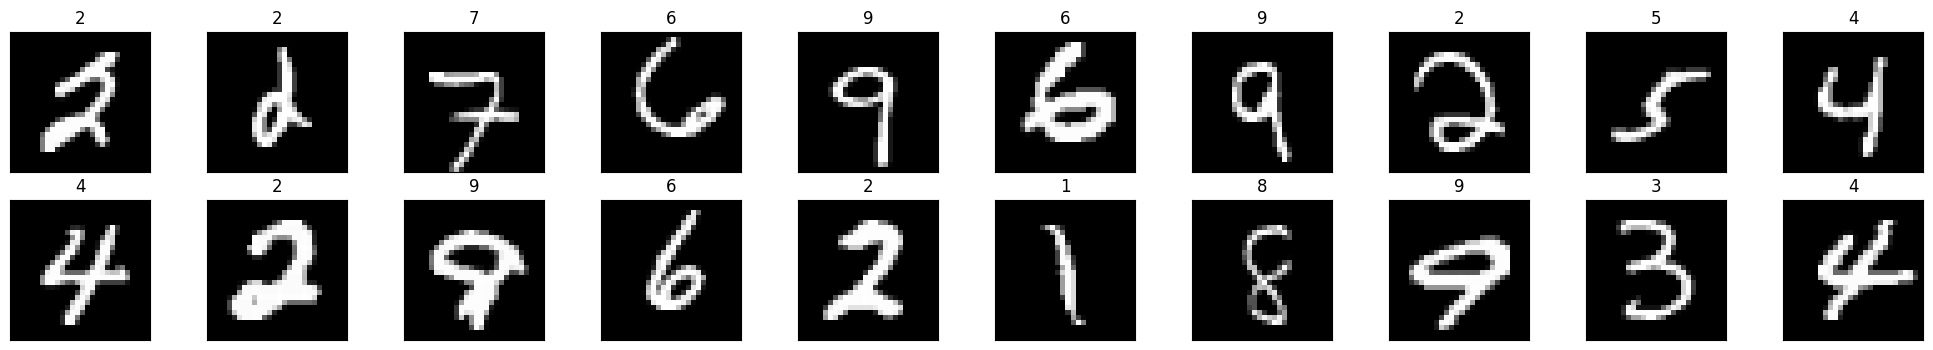

In [15]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
visualize_batch(images,labels)

First we train the model using the training set wrapped in a DataLoader. What is important to notice here is that this time you load a batch of images every iteration instead of one image + label. This means that every iteration you will create predictions for 128 images, as we set the batch size at 128.

In [16]:
# Define Model
model = CNN().to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0015)

# Execute Training
for batch in tqdm(train_loader):
    # Prepare batch data
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    # Generate prediction
    predictions = model(images)
    # Calculate loss
    loss = criterion(predictions, labels)
    # Compute gradients
    loss.backward()
    # Update weights
    optimizer.step()
    # Reset gradients
    optimizer.zero_grad()

100%|██████████| 469/469 [00:15<00:00, 31.13it/s]


Did you notice that using DataLoaders to load the data in batches speeds up training time?? After training, we test the model on the test set:

In [17]:
# Execute Testing
test_loss = []
test_acc = []
with torch.no_grad():
    model.eval()
    for batch in tqdm(test_loader):
        # Prepare batch data
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        # Generate predictions
        predictions = model(images)
        # Calculate loss
        loss = criterion(predictions, labels)
        # Calculate accuracy
        acc = accuracy(predictions, labels)
        # Store batch results
        test_loss.append(loss)
        test_acc.append(acc)

# Display Results
print("Test Loss: ", round(torch.stack(test_loss).mean().item(),2))
print("Test Accuracy: ", round(torch.stack(test_acc).mean().item()*100.0,2))

100%|██████████| 79/79 [00:02<00:00, 33.82it/s]

Test Loss:  1.5
Test Accuracy:  95.95


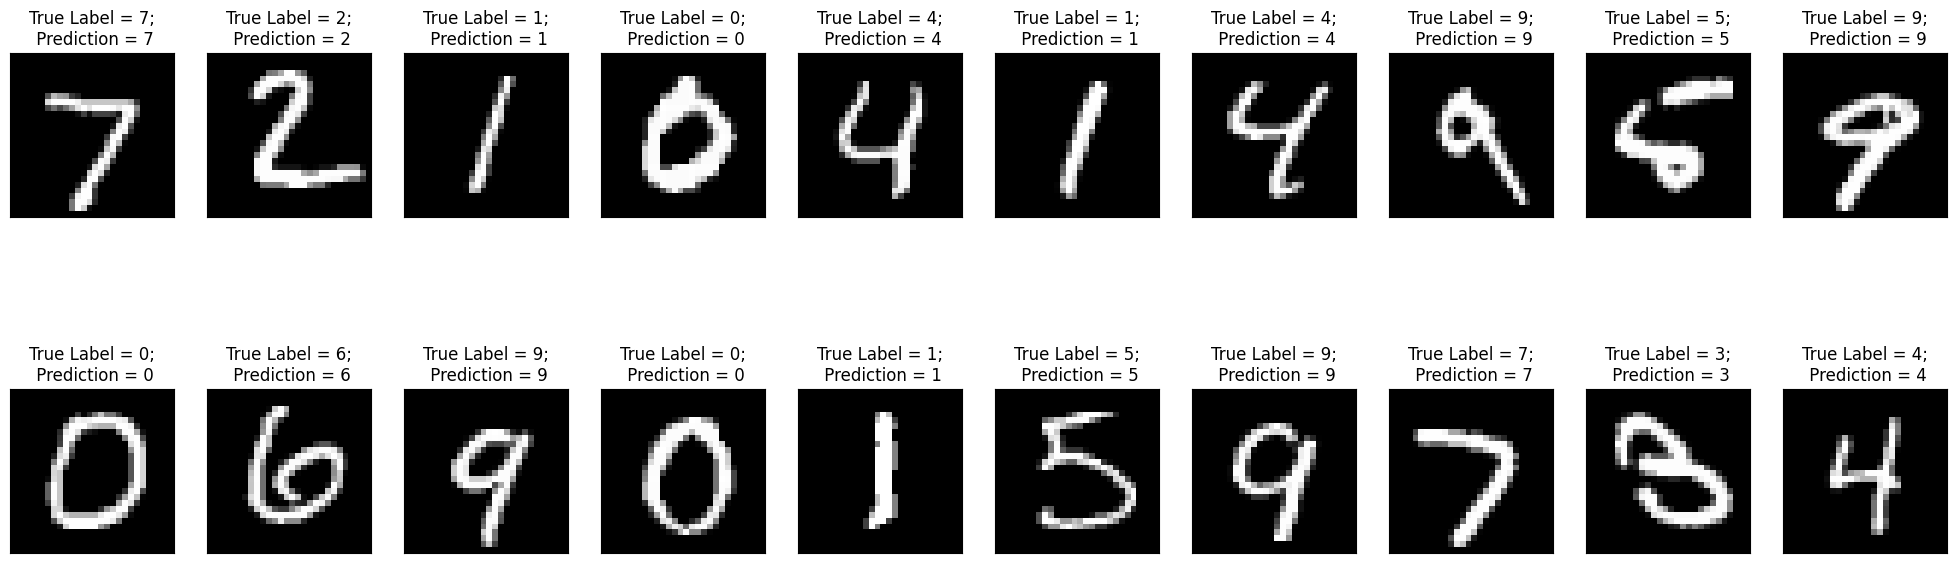

In [18]:
# obtain one batch of training images
with torch.no_grad():
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)
    # Generate predictions
    predictions = model(images)
    plot_predictions(images,labels,torch.max(predictions,dim=1)[1])

## Training with Validation Set

Next we show you how to split the original training set into a smaller training set and a validation set. This validation set can be used to validate/evaluate your model during training time without already using the test set. As you might want to train your model in multiple runs you want to prevent it overfitting on the test set. So by evaluating it on a validation set you can still tweak the model and only if you think your model is ready you can test it on the entire test set to obtain a valid performance measure.

We split the training set into `train_set` of size 50.000 and `val_set` of size 10.000. We then wrap them in to DataLoaders with a batch size again set to 128 and for the `train_set` we set shuffle to True, we set shuffle to False for the validation set to get reliable evaluation scores.

In [19]:
train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)

The remainder of the code is the same except that we first test the model on the validation set and in the end we also test it on the test set. What you will probably notice is that the validation and test accuracy are not as high as the previous test accuracy. A reasonable explanation is that you train on less samples than before. The original training set contains 60.000 samples and now you keep 10.000 aside for your validation set.

In [20]:
# Define Model
model = CNN().to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0015)

# Execute Training
for batch in tqdm(train_loader):
    # Prepare batch data
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    # Generate prediction
    predictions = model(images)
    # Calculate loss
    loss = criterion(predictions, labels)
    # Compute gradients
    loss.backward()
    # Update weights
    optimizer.step()
    # Reset gradients
    optimizer.zero_grad()

100%|██████████| 391/391 [00:12<00:00, 30.77it/s]


In [21]:
# Execute Validation
val_loss = []
val_acc = []
with torch.no_grad():
    model.eval()
    for batch in tqdm(val_loader):
        # Prepare batch data
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        # Generate predictions
        predictions = model(images)
        # Calculate loss
        loss = criterion(predictions, labels)
        # Calculate accuracy
        acc = accuracy(predictions, labels)
        # Store batch results
        val_loss.append(loss)
        val_acc.append(acc)

# Display Results
print("Validation Loss: ", round(torch.stack(val_loss).mean().item(),2))
print("Validation Accuracy: ", round(torch.stack(val_acc).mean().item()*100.0,2))

100%|██████████| 79/79 [00:02<00:00, 37.78it/s]

Validation Loss:  1.51
Validation Accuracy:  95.51


In [22]:
# Execute Testing
test_loss = []
test_acc = []
with torch.no_grad():
    model.eval()
    for batch in tqdm(test_loader):
        # Prepare batch data
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        # Generate predictions
        predictions = model(images)
        # Calculate loss
        loss = criterion(predictions, labels)
        # Calculate accuracy
        acc = accuracy(predictions, labels)
        # Store batch results
        test_loss.append(loss)
        test_acc.append(acc)

# Display Results
print("Test Loss: ", round(torch.stack(test_loss).mean().item(),2))
print("Test Accuracy: ", round(torch.stack(test_acc).mean().item()*100.0,2))

100%|██████████| 79/79 [00:02<00:00, 35.99it/s]

Test Loss:  1.5
Test Accuracy:  95.97


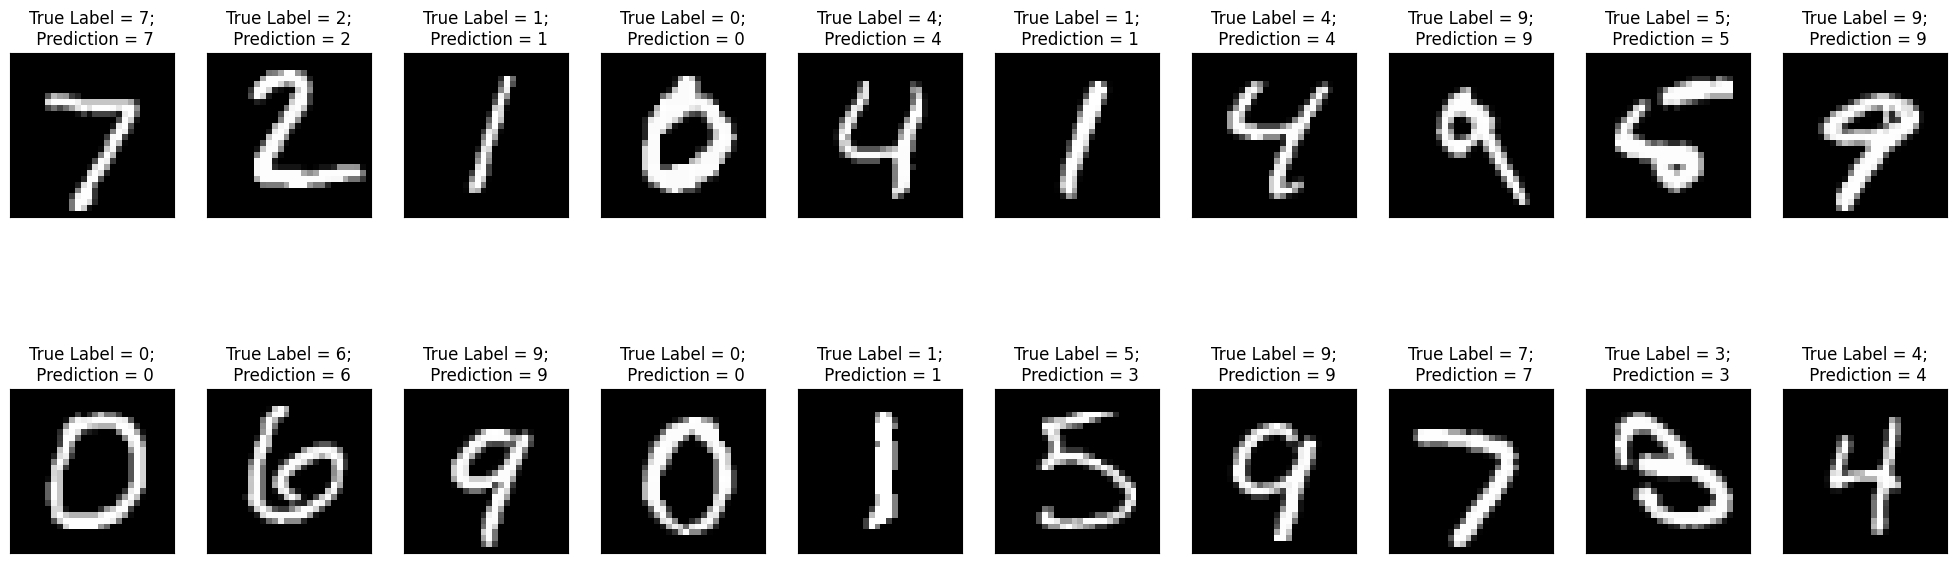

In [23]:
# obtain one batch of training images
with torch.no_grad():
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)
    # Generate predictions
    predictions = model(images)
    plot_predictions(images,labels,torch.max(predictions,dim=1)[1])

## Training in multiple epochs

Aside from evaluating your model on a validation set inbetween, you might also want to train your model for multiple runs. Meaning you train it on the same training samples multiple times so it might learn more. Here we show you how to run it using multiple runs/epochs:

In [24]:
# Define Model
model = CNN().to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0015)

# Determine number of epochs:
num_epochs = 5

# Execute Training
val_loss = []
val_acc = []
for epoch in range(num_epochs):
    print("Epoch: ", epoch+1)
    
    # Training Phase
    for batch in tqdm(train_loader):
        # Prepare batch data
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        # Generate prediction
        predictions = model(images)
        # Calculate loss
        loss = criterion(predictions, labels)
        # Compute gradients
        loss.backward()
        # Update weights
        optimizer.step()
        # Reset gradients
        optimizer.zero_grad()

    # Execute Validation
    batch_val_losses = []
    batch_val_accs = []
    with torch.no_grad():
        model.eval()
        for batch in tqdm(val_loader):
            # Prepare batch data
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            # Generate predictions
            predictions = model(images)
            # Calculate loss
            batch_val_loss = criterion(predictions, labels)
            # Calculate accuracy
            batch_val_acc = accuracy(predictions, labels)
            # Store batch results
            batch_val_losses.append(batch_val_loss)
            batch_val_accs.append(batch_val_acc)

    epoch_val_loss = torch.stack(batch_val_losses).mean()
    epoch_val_acc = torch.stack(batch_val_accs).mean()
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

print("Validation Loss: ", round(torch.stack(val_loss).mean().item(),2))
print("Validation Accuracy: ", round(torch.stack(val_acc).mean().item()*100.0,2))

Epoch:  1


100%|██████████| 79/79 [00:02<00:00, 37.62it/s]


Epoch:  2


100%|██████████| 79/79 [00:02<00:00, 35.22it/s]


Epoch:  3


100%|██████████| 79/79 [00:02<00:00, 32.19it/s]


Epoch:  4


100%|██████████| 79/79 [00:02<00:00, 35.80it/s]


Epoch:  5


100%|██████████| 79/79 [00:02<00:00, 34.57it/s]

Validation Loss:  1.49
Validation Accuracy:  97.3


In [25]:
# Execute Testing
test_loss = []
test_acc = []
with torch.no_grad():
    model.eval()
    for batch in tqdm(test_loader):
        # Prepare batch data
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        # Generate predictions
        predictions = model(images)
        # Calculate loss
        batch_test_loss = criterion(predictions, labels)
        # Calculate accuracy
        batch_test_acc = accuracy(predictions, labels)
        # Store batch results
        test_loss.append(batch_test_loss)
        test_acc.append(batch_test_acc)

# Display Results
print("Test Loss: ", round(torch.stack(test_loss).mean().item(),2))
print("Test Accuracy: ", round(torch.stack(test_acc).mean().item()*100.0,2))

100%|██████████| 79/79 [00:02<00:00, 36.23it/s]

Test Loss:  1.47
Test Accuracy:  98.66


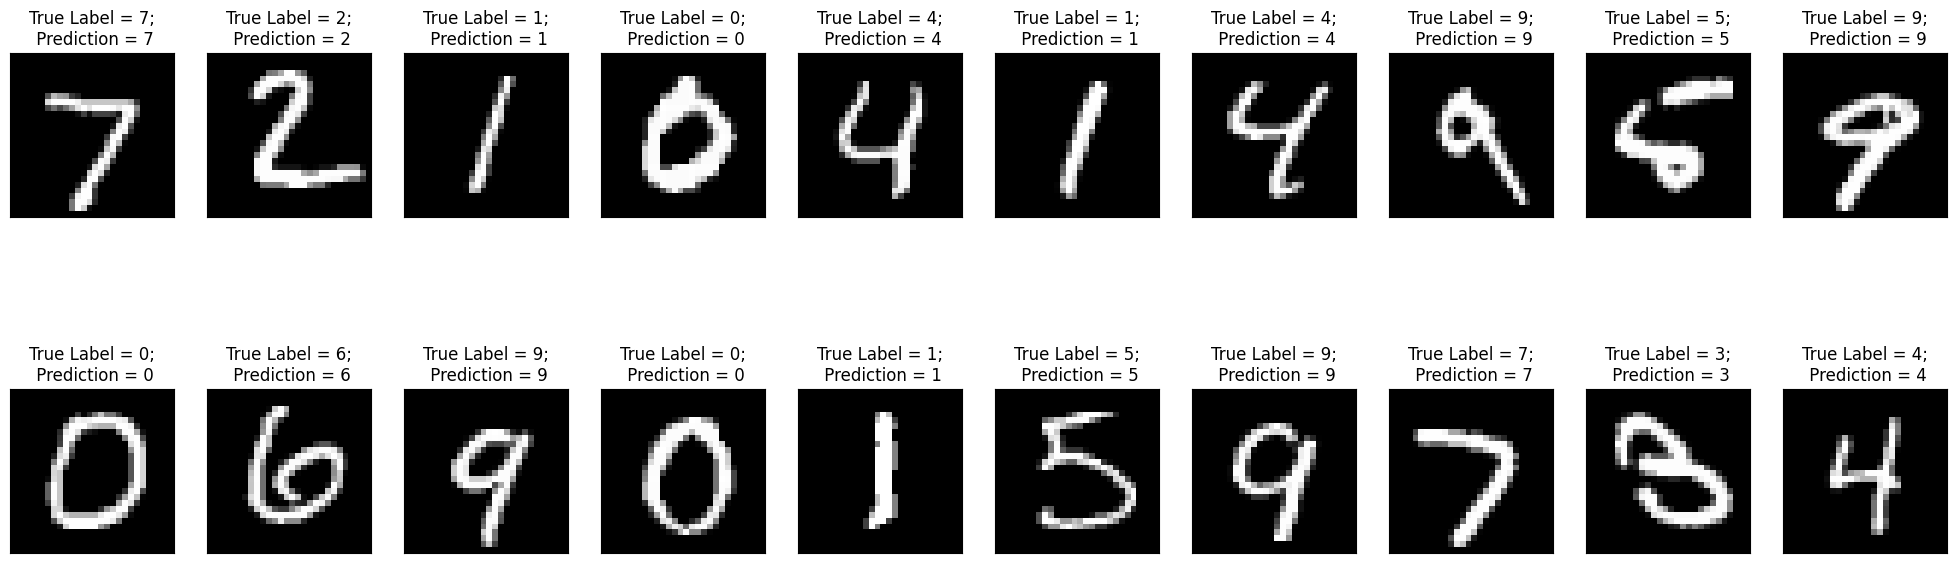

In [26]:
# obtain one batch of training images
with torch.no_grad():
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)
    # Generate predictions
    predictions = model(images)
    plot_predictions(images,labels,torch.max(predictions,dim=1)[1])

Below we plot the validation loss (red) and accuracy (blue) over multiple epochs:

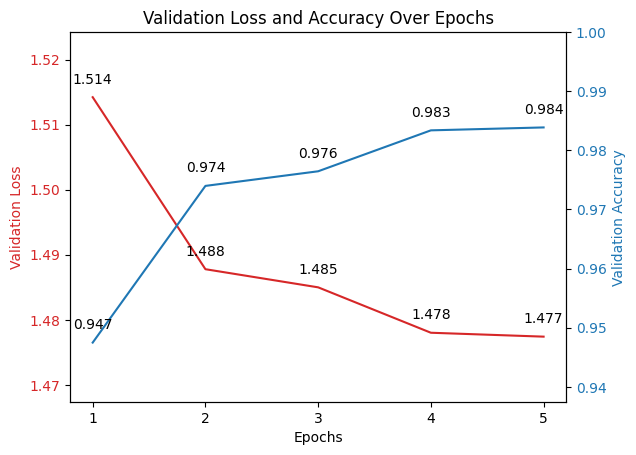

In [27]:
# Plot Training
import matplotlib.pyplot as plt

val_losses = torch.stack(val_loss).cpu()
val_accs = torch.stack(val_acc).cpu()

epochs = range(1, len(val_losses)+1)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel("Validation Loss", color="tab:red")
ax1.plot(epochs, val_losses, color="tab:red")
ax1.tick_params(axis='y', labelcolor="tab:red")

# Set y-axis range for validation loss
ax1.set_ylim([min(val_losses) - 0.01, max(val_losses) + 0.01]) 

# Annotating each point for val_loss
for i, txt in enumerate(val_losses):
    ax1.annotate(f"{txt:.3f}", (epochs[i], val_losses[i]), textcoords="offset points", xytext=(0,10), ha='center', color='black')

ax2 = ax1.twinx()
ax2.set_ylabel('Validation Accuracy', color="tab:blue")
ax2.plot(epochs, val_accs, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Set y-axis range for validation accuracy
ax2.set_ylim([min(val_accs) - 0.01, 1.0]) 

# Annotating each point for val_acc
for i, txt in enumerate(val_accs):
    ax2.annotate(f"{txt:.3f}", (epochs[i], val_accs[i]), textcoords="offset points", xytext=(0,10), ha='center', color='black')


plt.xticks(epochs)

plt.title("Validation Loss and Accuracy Over Epochs")
plt.show()

As you can see the accuracy was already high at the first epoch, but training the model for multiple epochs resulted in a higher accuracy. This does not mean that more epochs will always end up in a higher accuracy. You will need to experiment with the number of epochs yourself. Maybe in just a few epochs you already reach the optimal performance.

## Entire Training Process Nicely Split

The next code block contains all code from above nicely split up in multiple methods.

In [28]:
def training_step(model, batch, criterion):
    # Prepare batch data
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    # Generate predictions
    predictions = model(images)
    # Calculate Loss
    loss = criterion(predictions, labels)
    return loss

def validation_step(model, batch, criterion):
    # Prepare batch data
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    # Generate predictions
    predictions = model(images)
    # Calculate Loss
    loss = criterion(predictions, labels)
    # Calculate Accuracy
    acc = accuracy(predictions, labels)
    return {'val_loss': loss, 'val_acc': acc}

def validate(model, val_loader, criterion):
    with torch.no_grad():
        model.eval()
        outputs = [validation_step(model, batch, criterion) for batch in val_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(epoch, result):
    print(f"val_loss: {result['val_loss']:.2f}, val_acc: {result['val_acc']:.2f}")

def train(model, num_epochs, criterion, optimizer, train_loader, val_loader):
    history = []
    for epoch in range(num_epochs):
        print("Epoch: ", epoch+1)
        # Training Phase
        for batch in train_loader:
            # Calculate Loss
            loss = training_step(model,batch,criterion)
            # Compute Gradients
            loss.backward()
            # Update weights
            optimizer.step()
            # Reset Gradients
            optimizer.zero_grad()

        # Validation Phase
        result = validate(model, val_loader, criterion)
        epoch_end(epoch, result)
        history.append(result)
    return history

def test(model, criterion, optimizer, test_loader):
    # Execute Testing
    test_loss = []
    test_acc = []
    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_loader):
            # Prepare batch data
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            # Generate predictions
            predictions = model(images)
            # Calculate loss
            batch_test_loss = criterion(predictions, labels)
            # Calculate accuracy
            batch_test_acc = accuracy(predictions, labels)
            # Store batch results
            test_loss.append(batch_test_loss)
            test_acc.append(batch_test_acc)
    
    # Display Results
    print("Test Loss: ", round(torch.stack(test_loss).mean().item(),2))
    print("Test Accuracy: ", round(torch.stack(test_acc).mean().item()*100.0,2))

Let's use these methods to train, validate and test your model.

In [29]:
# Define Model
model = CNN().to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0015)

# Determine number of epochs:
num_epochs = 5

# Training
history = train(model, num_epochs, criterion, optimizer, train_loader, val_loader)

# Testing
test(model, criterion, optimizer, test_loader)

Epoch:  1
val_loss: 1.51, val_acc: 0.95
Epoch:  2
val_loss: 1.49, val_acc: 0.98
Epoch:  3
val_loss: 1.48, val_acc: 0.98
Epoch:  4
val_loss: 1.48, val_acc: 0.98
Epoch:  5
val_loss: 1.48, val_acc: 0.99


100%|██████████| 79/79 [00:02<00:00, 37.87it/s]

Test Loss:  1.47
Test Accuracy:  98.72


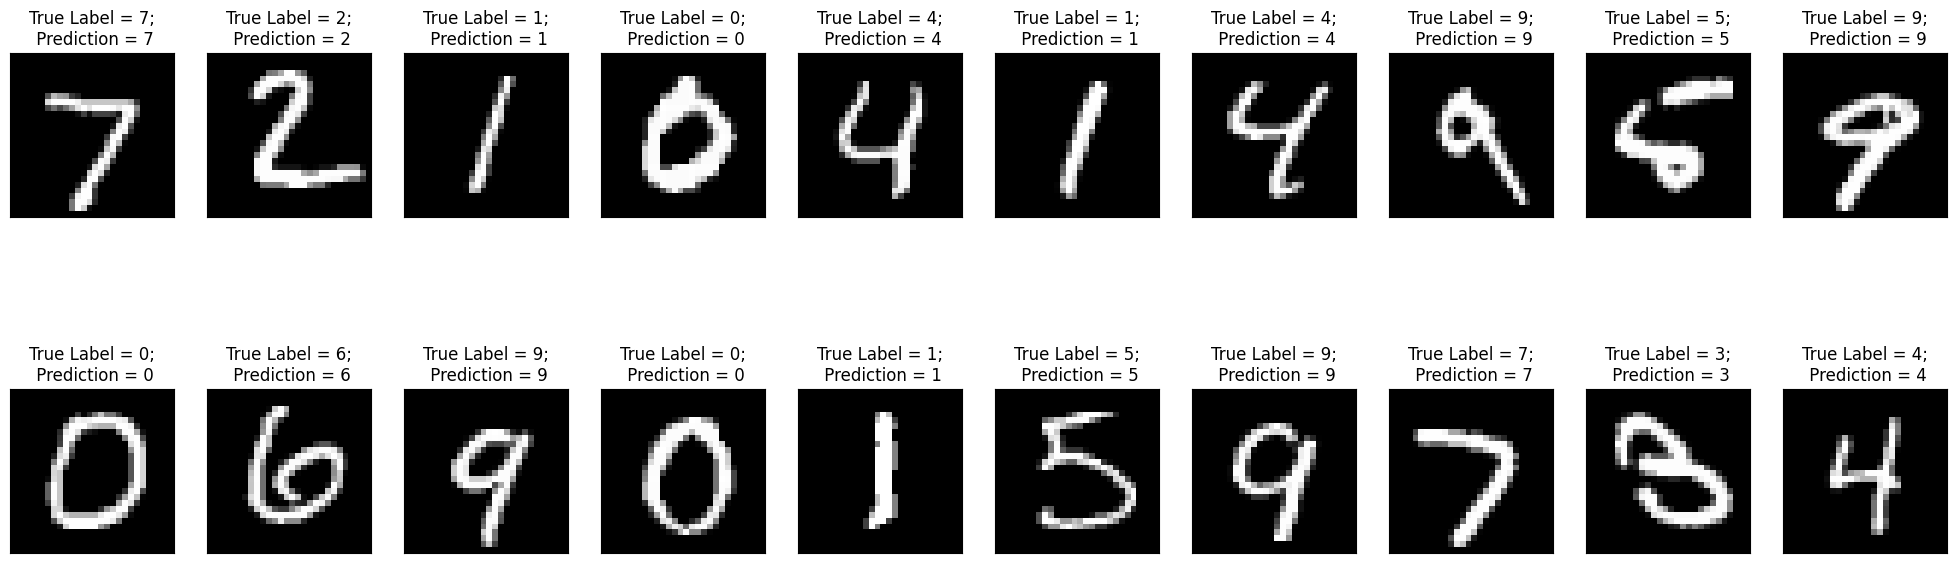

In [30]:
# obtain one batch of training images
with torch.no_grad():
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = (images.view(-1,1,28,28)).type(torch.FloatTensor).to(device)
    labels = labels.to(device)
    # Generate predictions
    predictions = model(images)
    plot_predictions(images,labels,torch.max(predictions,dim=1)[1])

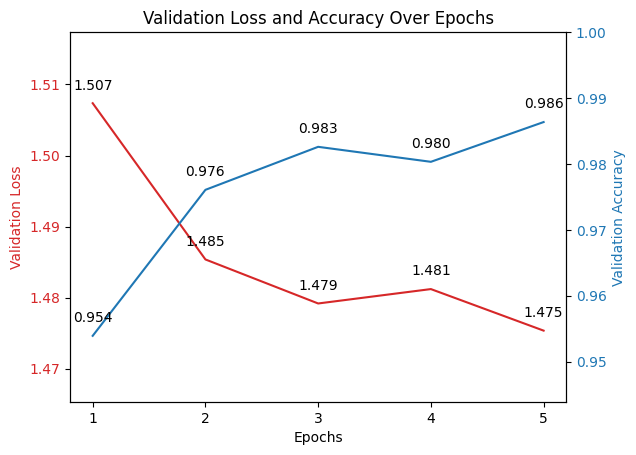

In [31]:
# Plot Training
import matplotlib.pyplot as plt

val_losses = [entry['val_loss'] for entry in history]
val_accs = [entry['val_acc'] for entry in history]

epochs = range(1, len(history)+1)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel("Validation Loss", color="tab:red")
ax1.plot(epochs, val_losses, color="tab:red")
ax1.tick_params(axis='y', labelcolor="tab:red")

# Set y-axis range for validation loss
ax1.set_ylim([min(val_losses) - 0.01, max(val_losses) + 0.01]) 

# Annotating each point for val_loss
for i, txt in enumerate(val_losses):
    ax1.annotate(f"{txt:.3f}", (epochs[i], val_losses[i]), textcoords="offset points", xytext=(0,10), ha='center', color='black')


ax2 = ax1.twinx()
ax2.set_ylabel('Validation Accuracy', color="tab:blue")
ax2.plot(epochs, val_accs, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Set y-axis range for validation accuracy
ax2.set_ylim([min(val_accs) - 0.01, 1.0]) 

# Annotating each point for val_acc
for i, txt in enumerate(val_accs):
    ax2.annotate(f"{txt:.3f}", (epochs[i], val_accs[i]), textcoords="offset points", xytext=(0,10), ha='center', color='black')

plt.xticks(epochs)

plt.title("Validation Loss and Accuracy Over Epochs")
plt.show()

## Cross Validation

Finally, we show you how to perform K-Fold Cross Validation. With K-Fold Cross Validation you pick a number of folds (K). In our case we pick 5 folds. Then we split the training set into k equal parts (so called folds). We pick k-1 as the training set and one fold will be the validation set. We train the model, just like before, using the training set and then validate it on the validation set. You save the validation score and then you pick new k equal folds. From these new folds you again create a training and validation set and you repeat the process. For more information read this blog on [neptune.ai](https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right). 

The idea is that this way you train and validate your model multiple times and also use your entire training set. You perform training and testing on several different parts of the dataset and thus it should give more stable and trustworthy results. The downside is that this process can become really expensive and time-consuming.

For this course we do not expect you to perform K-Fold Cross Validation. However, you are free to apply it.

In [32]:
from sklearn.model_selection import KFold

In [34]:
# DataLoaders code
train_set = torchvision.datasets.MNIST(root='d:\Datasets', transform=transforms.Compose([transforms.ToTensor()]), download=True, train=True)
test_set = torchvision.datasets.MNIST(root='d:\Datasets', transform=transforms.Compose([transforms.ToTensor()]), download=True, train=False)

k_folds = 5
batch_size = 128
num_epochs = 5

kf = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_set)):
    print("Fold ", fold+1)
    print("-------")

    # Define the data loaders for the current fold
    train_loader = DataLoader(dataset=train_set,batch_size=batch_size,sampler=torch.utils.data.SubsetRandomSampler(train_idx))
    val_loader = DataLoader(dataset=train_set,batch_size=batch_size,sampler=torch.utils.data.SubsetRandomSampler(val_idx))

    # Initialize the model and optimizer
    model = CNN().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0015)

    fold_results = train(model, num_epochs, criterion, optimizer, train_loader, val_loader)

    # Testing
    test(model, criterion, optimizer, test_loader)
    print("\n")

Fold  1
-------
Epoch:  1
val_loss: 1.50, val_acc: 0.96
Epoch:  2
val_loss: 1.49, val_acc: 0.97
Epoch:  3
val_loss: 1.49, val_acc: 0.97
Epoch:  4
val_loss: 1.48, val_acc: 0.98
Epoch:  5
val_loss: 1.49, val_acc: 0.98


100%|██████████| 79/79 [00:02<00:00, 36.04it/s]


Test Loss:  1.49
Test Accuracy:  97.54


Fold  2
-------
Epoch:  1
val_loss: 1.50, val_acc: 0.96
Epoch:  2
val_loss: 1.49, val_acc: 0.97
Epoch:  3
val_loss: 1.48, val_acc: 0.98
Epoch:  4
val_loss: 1.48, val_acc: 0.98
Epoch:  5
val_loss: 1.48, val_acc: 0.98


100%|██████████| 79/79 [00:02<00:00, 36.44it/s]


Test Loss:  1.47
Test Accuracy:  98.65


Fold  3
-------
Epoch:  1
val_loss: 1.51, val_acc: 0.95
Epoch:  2
val_loss: 1.48, val_acc: 0.98
Epoch:  3
val_loss: 1.48, val_acc: 0.98
Epoch:  4
val_loss: 1.48, val_acc: 0.98
Epoch:  5
val_loss: 1.48, val_acc: 0.98


100%|██████████| 79/79 [00:02<00:00, 36.05it/s]


Test Loss:  1.48
Test Accuracy:  98.46


Fold  4
-------
Epoch:  1
val_loss: 1.59, val_acc: 0.87
Epoch:  2
val_loss: 1.49, val_acc: 0.97
Epoch:  3
val_loss: 1.48, val_acc: 0.98
Epoch:  4
val_loss: 1.48, val_acc: 0.98
Epoch:  5
val_loss: 1.48, val_acc: 0.98


100%|██████████| 79/79 [00:02<00:00, 31.37it/s]


Test Loss:  1.48
Test Accuracy:  98.37


Fold  5
-------
Epoch:  1
val_loss: 1.50, val_acc: 0.96
Epoch:  2
val_loss: 1.49, val_acc: 0.97
Epoch:  3
val_loss: 1.48, val_acc: 0.98
Epoch:  4
val_loss: 1.48, val_acc: 0.98
Epoch:  5
val_loss: 1.48, val_acc: 0.98


100%|██████████| 79/79 [00:02<00:00, 35.55it/s]


Test Loss:  1.47
Test Accuracy:  98.8




## Modify individual samples and labels

Finally, we showed you several ways of training and evaluating your model making use of the original MNIST dataset.

Let's say you want modify the existing MNIST dataset. Maybe you want to change the label of the original samples, so change the label 7 to 11 for every image of the number 7. Below we will show you how you can perform such modifications and then train your model on this modified dataset.

First we create a new custom dataset class, let's call it CustomDataset:

In [35]:
class CustomDataset(Dataset):

    def __init__(self, original_dataset, source_label=None, target_label=None):
        self.original_dataset = original_dataset
        self.source_label = source_label
        self.target_label = target_label
        self.custom_dataset = self.get_dataset()

    def __len__(self):
        return len(self.custom_dataset)

    def __getitem__(self,idx):
        image, label = self.custom_dataset[idx]
        return image, label

    def get_dataset(self):
        custom_ds = []

        for idx, (image, label) in enumerate(self.original_dataset):
            if label == self.source_label:
                insert = (image, self.target_label)
            else:
                insert = (image, label)
            custom_ds.append(insert)

        return custom_ds

It contains all methods needed for it to be a Dataset class and also an additional method named `get_dataset()`. This method will iterate over the original image and labels and if the original label is equal to a specific label (which you can pick yourself), then we will change this original label to a new target label (which you can also pick yourself). Keep in mind the new target labels should be between 0 and 9 (This is related to the MNIST dataset labels and some training procedure design decisions). 

Let's say you want to change all images with the label 8 to have a new label of 0:

In [36]:
custom_train_set = CustomDataset(train_set, source_label=8, target_label = 0)

Now lets wrap it in a DataLoader and get a batch of images.

In [37]:
custom_train_loader = DataLoader(custom_train_set, batch_size=128, shuffle=True)
dataiter = iter(custom_train_loader)

If you then execute the code snippet below we might see some images of the number 8 with their new label set to 0. If you do not see any of these images try executing the code snippet again until you do.

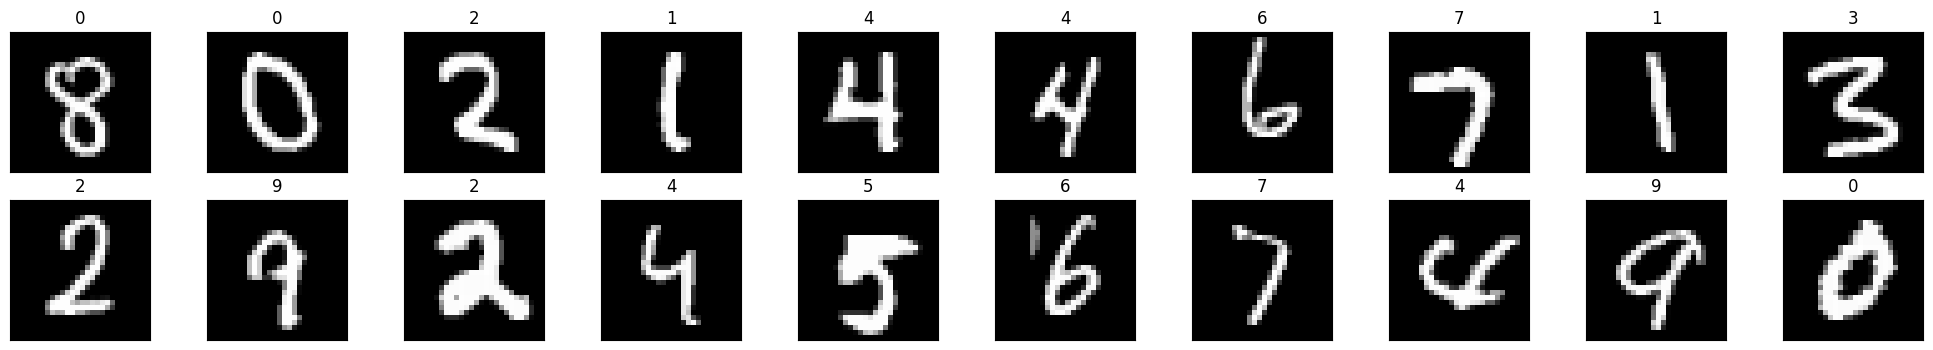

In [38]:
dataiter = iter(custom_train_loader)
images, labels = next(dataiter)
visualize_batch(images,labels)

Now we can continue training and validation just like we did before:

In [39]:
custom_train_set = CustomDataset(train_set, source_label=8, target_label = 0)
custom_train_set, custom_val_set = torch.utils.data.random_split(custom_train_set, [50000, 10000])
train_loader = DataLoader(custom_train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(custom_val_set, batch_size=64, shuffle=False)

In [40]:
# Define Model
model = CNN().to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0015)

# Determine number of epochs:
num_epochs = 5

# Training
history = train(model, num_epochs, criterion, optimizer, train_loader, val_loader)

Epoch:  1
val_loss: 1.51, val_acc: 0.95
Epoch:  2
val_loss: 1.49, val_acc: 0.97
Epoch:  3
val_loss: 1.48, val_acc: 0.98
Epoch:  4
val_loss: 1.48, val_acc: 0.99
Epoch:  5
val_loss: 1.48, val_acc: 0.98


In [41]:
custom_test_set = CustomDataset(test_set, source_label=8, target_label=0)
test_loader = DataLoader(custom_test_set, batch_size=64, shuffle=False)

In [42]:
# Testing
test(model, criterion, optimizer, test_loader)

100%|██████████| 157/157 [00:01<00:00, 119.21it/s]

Test Loss:  1.48
Test Accuracy:  98.1


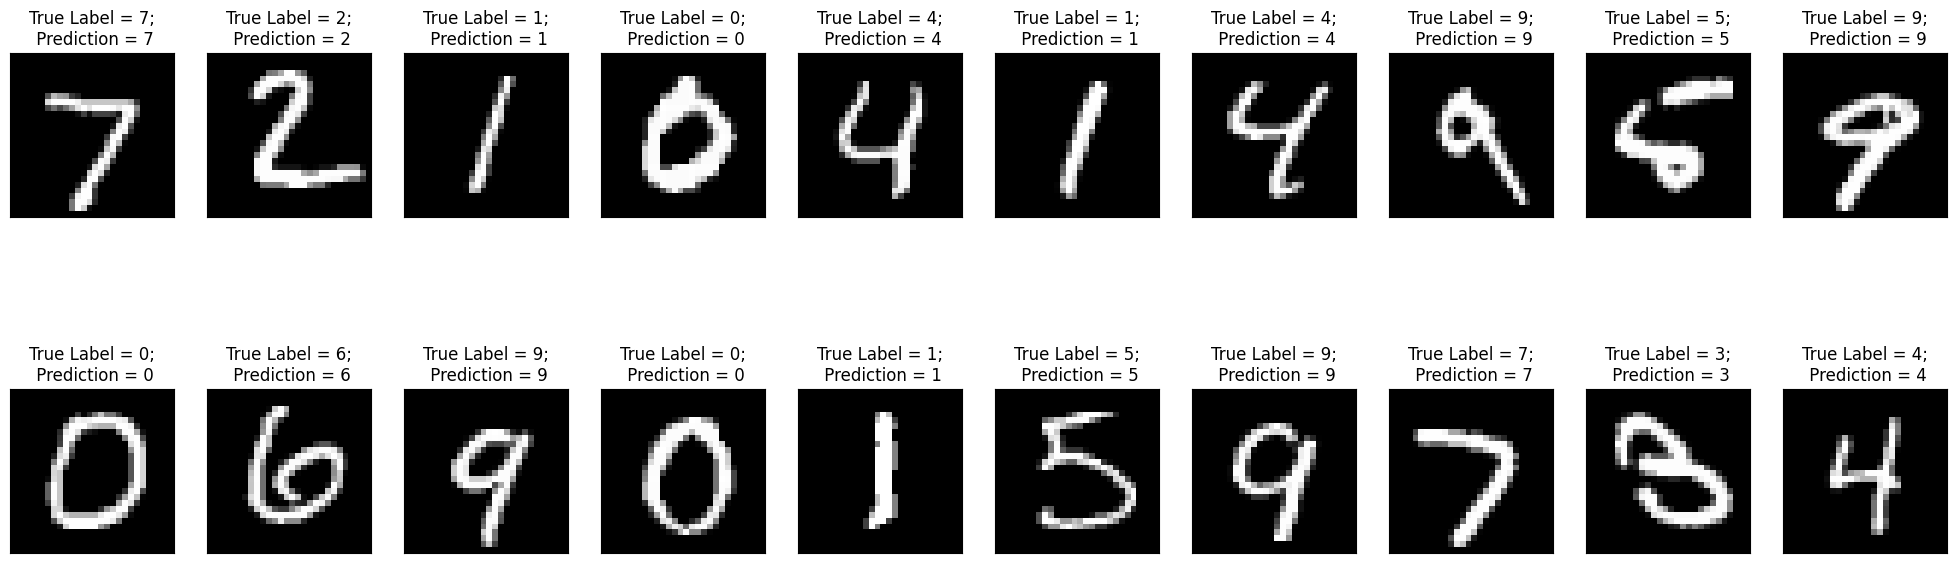

In [43]:
# obtain one batch of training images
with torch.no_grad():
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = (images.view(-1,1,28,28)).type(torch.FloatTensor).to(device)
    labels = labels.to(device)
    # Generate predictions
    predictions = model(images)
    plot_predictions(images,labels,torch.max(predictions,dim=1)[1])

# Exercises (CIFAR-10)

Now we ask you to load the CIFAR-10 dataset and train your own model on it. Below you will find some code snippets and in some you need to fill in the blanks. Using what we showed you above, you should be able to train and test your own model on this dataset. Keep in mind that the data is different from the MNIST dataset.

## Imports

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

#PyTorch Specific libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

## Data

In [75]:
train_set = torchvision.datasets.CIFAR10(root='d:\Datasets', transform=transforms.Compose([transforms.ToTensor()]), download=True, train=True)
test_set = torchvision.datasets.CIFAR10(root='d:\Datasets', transform=transforms.Compose([transforms.ToTensor()]), download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


## Create Validation Set

In [76]:
train_set, val_set = torch.utils.data.random_split(train_set, [40000, 10000])

## DataLoaders

In [77]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

## Model

In [89]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=9, kernel_size=5, stride=1, padding=0, dilation=1),
            nn.MaxPool2d(kernel_size=2, stride=None, padding=0),
            nn.ReLU()
        )
        
        self.flatten = nn.Flatten()
        
        self.linear_block_1 = nn.Sequential(
            nn.Linear(in_features=9*14*14, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        
        self.linear_block_2 = nn.Sequential(
            nn.Linear(in_features=256, out_features=10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.flatten(x)
        x = self.linear_block_1(x)
        x = self.linear_block_2(x)
        
        return x

## Evaluation Metric

In [79]:
# Method to compute accuracy
def accuracy(outputs,labels):
    _, preds = torch.max(outputs, dim=1)
    return (torch.tensor(torch.sum(preds == labels).item() / len(preds)))

## Training Without DataLoader

In [90]:
# Define Model
model = CNN().to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Execute Training
for batch in tqdm(train_loader):
    # Prepare batch data
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    # Generate prediction
    predictions = model(images)
    # Calculate loss
    loss = criterion(predictions, labels)
    # Compute gradients
    loss.backward()
    # Update weights
    optimizer.step()
    # Reset gradients
    optimizer.zero_grad()

  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:10<00:00, 28.60it/s]


In [91]:
# Execute Testing
test_loss = []
test_acc = []
with torch.no_grad():
    model.eval()
    for batch in tqdm(test_loader):
        # Prepare batch data
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        # Generate predictions
        predictions = model(images)
        # Calculate loss
        loss = criterion(predictions, labels)
        # Calculate accuracy
        acc = accuracy(predictions, labels)
        # Store batch results
        test_loss.append(loss)
        test_acc.append(acc)

# Display Results
print("Test Loss: ", round(torch.stack(test_loss).mean().item(),2))
print("Test Accuracy: ", round(torch.stack(test_acc).mean().item()*100.0,2))

100%|██████████| 79/79 [00:03<00:00, 22.15it/s]

Test Loss:  2.08
Test Accuracy:  37.95


## Training in multiple Epochs

In [94]:
# Define Model
model = CNN().to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.005)

# Determine number of epochs:
num_epochs = 10

# Execute Training
val_loss = []
val_acc = []
for epoch in range(num_epochs):
    
    # Training Phase
    for batch in tqdm(train_loader):
        # Prepare batch data
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        # Generate prediction
        predictions = model(images)
        # Calculate loss
        loss = criterion(predictions, labels)
        # Compute gradients
        loss.backward()
        # Update weights
        optimizer.step()
        # Reset gradients
        optimizer.zero_grad()

    # Execute Validation
    batch_val_losses = []
    batch_val_accs = []
    with torch.no_grad():
        model.eval()
        for batch in tqdm(val_loader):
            # Prepare batch data
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            # Generate predictions
            predictions = model(images)
            # Calculate loss
            batch_val_loss = criterion(predictions, labels)
            # Calculate accuracy
            batch_val_acc = accuracy(predictions, labels)
            # Store batch results
            batch_val_losses.append(batch_val_loss)
            batch_val_accs.append(batch_val_acc)

    epoch_val_loss = torch.stack(batch_val_losses).mean()
    epoch_val_acc = torch.stack(batch_val_accs).mean()
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

print("Validation Loss: ", round(torch.stack(val_loss).mean().item(),2))
print("Validation Accuracy: ", round(torch.stack(val_acc).mean().item()*100.0,2))

  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:02<00:00, 29.10it/s]

Validation Loss:  2.01
Validation Accuracy:  44.37


In [95]:
# Execute Testing
test_loss = []
test_acc = []
with torch.no_grad():
    model.eval()
    for batch in tqdm(test_loader):
        # Prepare batch data
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        # Generate predictions
        predictions = model(images)
        # Calculate loss
        loss = criterion(predictions, labels)
        # Calculate accuracy
        acc = accuracy(predictions, labels)
        # Store batch results
        test_loss.append(loss)
        test_acc.append(acc)

# Display Results
print("Test Loss: ", round(torch.stack(test_loss).mean().item(),2))
print("Test Accuracy: ", round(torch.stack(test_acc).mean().item()*100.0,2))

100%|██████████| 79/79 [00:02<00:00, 27.32it/s]

Test Loss:  1.98
Test Accuracy:  47.78


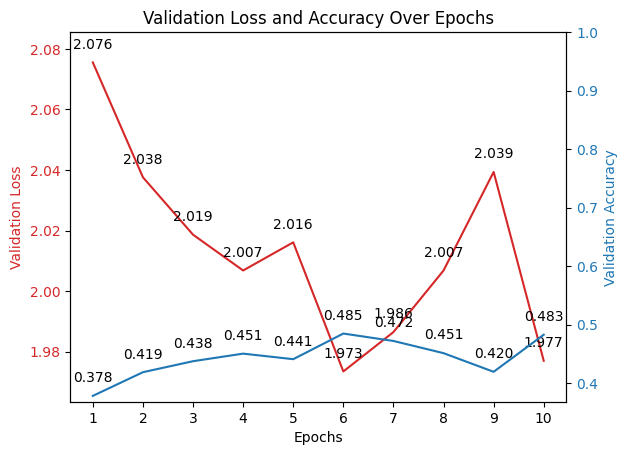

In [96]:
# Plot Training
import matplotlib.pyplot as plt

val_losses = torch.stack(val_loss).cpu()
val_accs = torch.stack(val_acc).cpu()

epochs = range(1, len(val_losses)+1)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel("Validation Loss", color="tab:red")
ax1.plot(epochs, val_losses, color="tab:red")
ax1.tick_params(axis='y', labelcolor="tab:red")

# Set y-axis range for validation loss
ax1.set_ylim([min(val_losses) - 0.01, max(val_losses) + 0.01]) 

# Annotating each point for val_loss
for i, txt in enumerate(val_losses):
    ax1.annotate(f"{txt:.3f}", (epochs[i], val_losses[i]), textcoords="offset points", xytext=(0,10), ha='center', color='black')

ax2 = ax1.twinx()
ax2.set_ylabel('Validation Accuracy', color="tab:blue")
ax2.plot(epochs, val_accs, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Set y-axis range for validation accuracy
ax2.set_ylim([min(val_accs) - 0.01, 1.0]) 

# Annotating each point for val_acc
for i, txt in enumerate(val_accs):
    ax2.annotate(f"{txt:.3f}", (epochs[i], val_accs[i]), textcoords="offset points", xytext=(0,10), ha='center', color='black')


plt.xticks(epochs)

plt.title("Validation Loss and Accuracy Over Epochs")
plt.show()